In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from configs import engram_dir

In [2]:
from scipy.stats import pearsonr

# Arguments

In [3]:
internal_dim = 96
generic_exp_name = 'test_altT' #'altT_eps0.4_mlen0_g0_tcm5_g0.9'
#generic_exp_name = 'altT_eps0.4_mlen2_g0.8_tcm0_g0'
episode = 30
#network_yaml = 'dm_small_encoder_large_q_v2'
network_yaml = 'dm_selq_v3'

# Directories

In [4]:
exp_name = f'{generic_exp_name}_{network_yaml}_dim{internal_dim}'
analysis_dir = f'{engram_dir}analysis/{exp_name}/'

# Load analysis

In [5]:
with open(f'{analysis_dir}representation_df_ep{episode}.p', 'rb') as f:
    repr_df = pickle.load(f)

In [6]:
y_locs = np.sort(np.unique(repr_df['y']))
x_locs = np.sort(np.unique(repr_df['x']))
n_y = y_locs.size
midpoint = x_locs[x_locs.size//2]

In [7]:
def cos_sim(A, B):
    return np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B))

In [8]:
def relu(x):
    x = x.copy()
    x[x<0] = 0
    return x

375.0
405.0


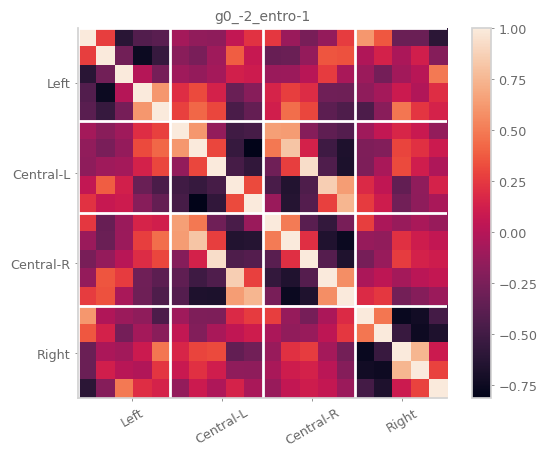

415.0


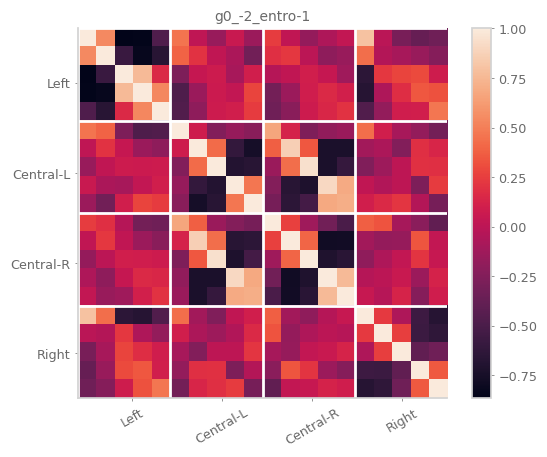

415.0


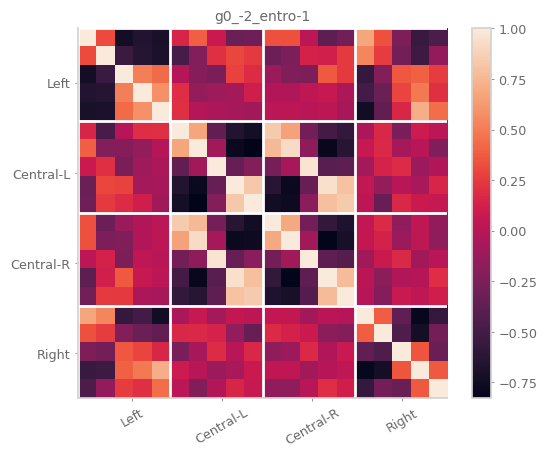

380.0
379.0
405.0


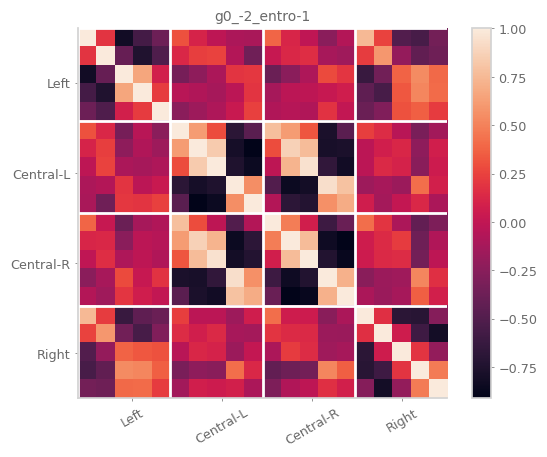

415.0


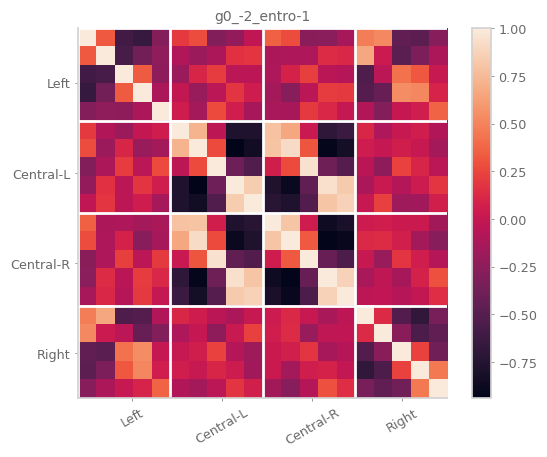

415.0


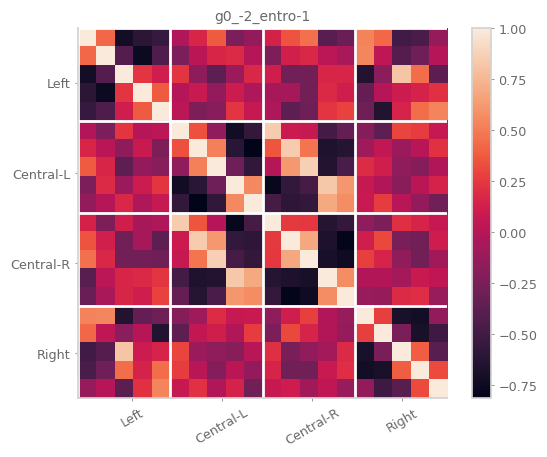

415.0


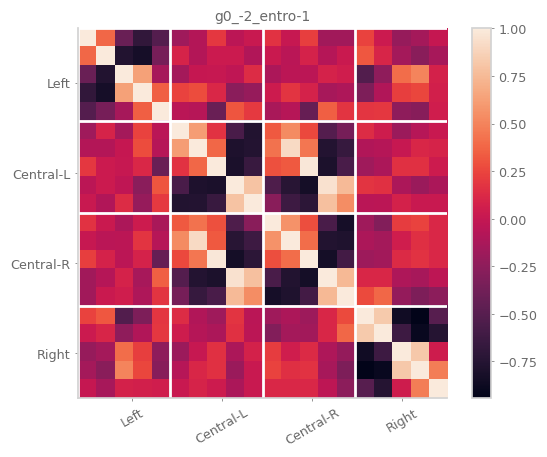

375.0
405.0


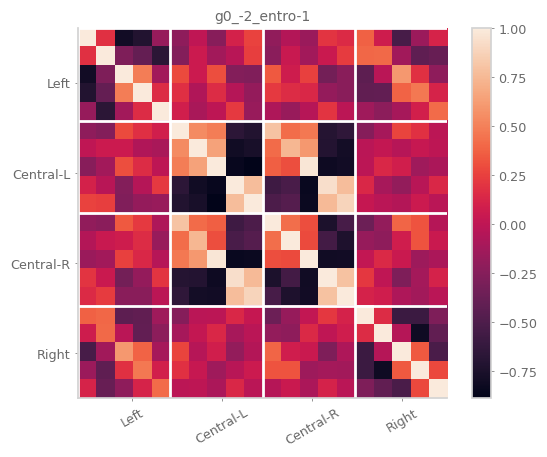

347.0
385.0
380.0
415.0


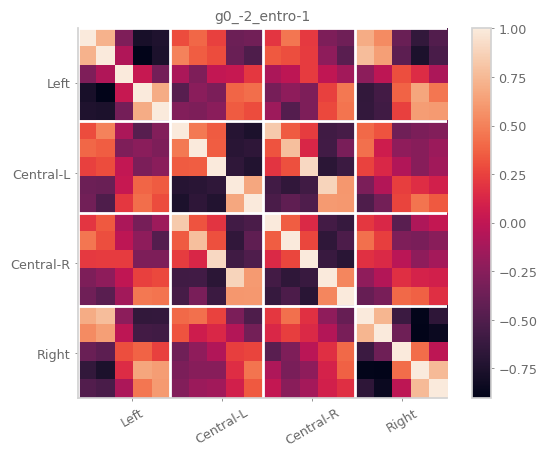

370.0
415.0


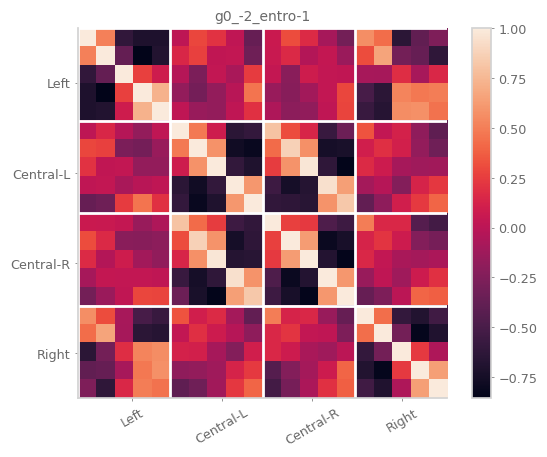

405.0


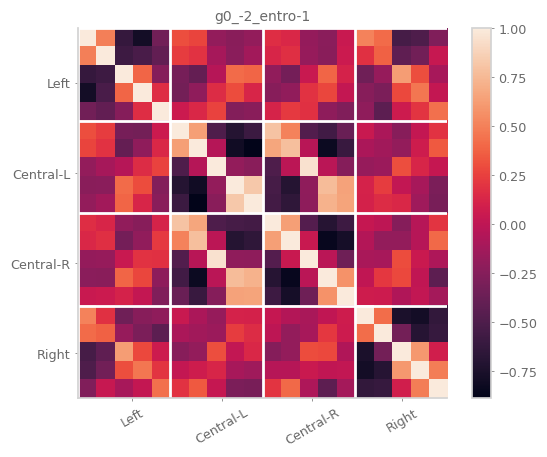

405.0


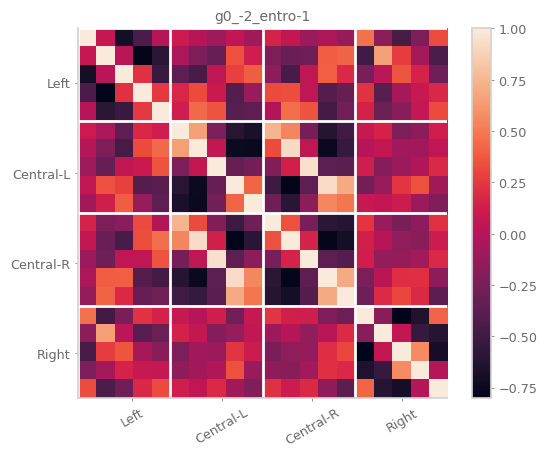

370.0
380.0
405.0


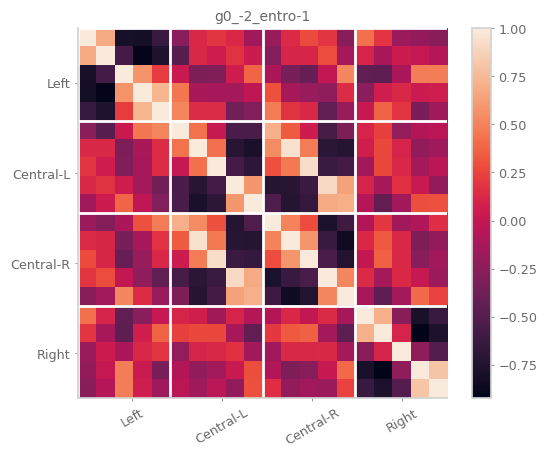

404.0


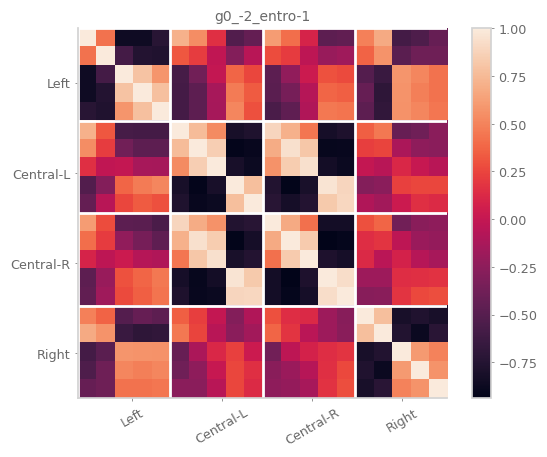

415.0


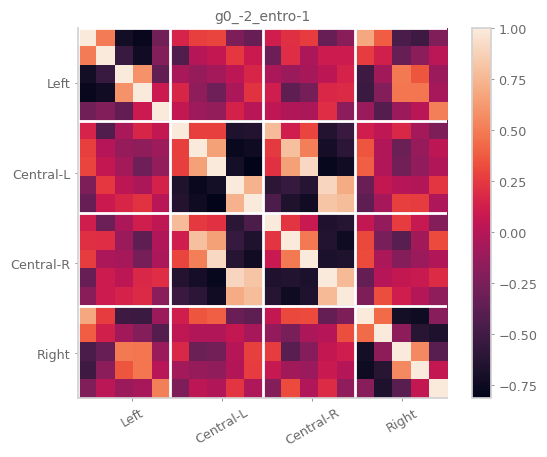

405.0


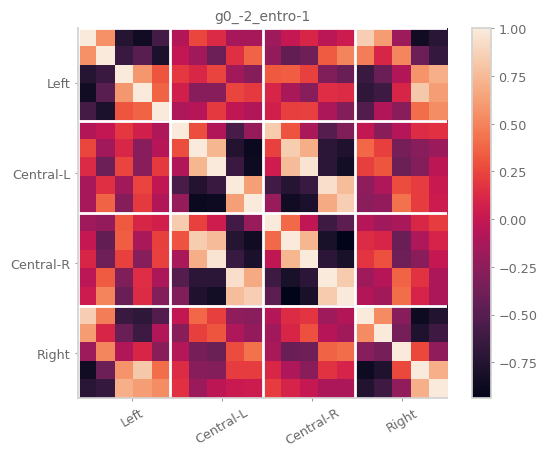

415.0


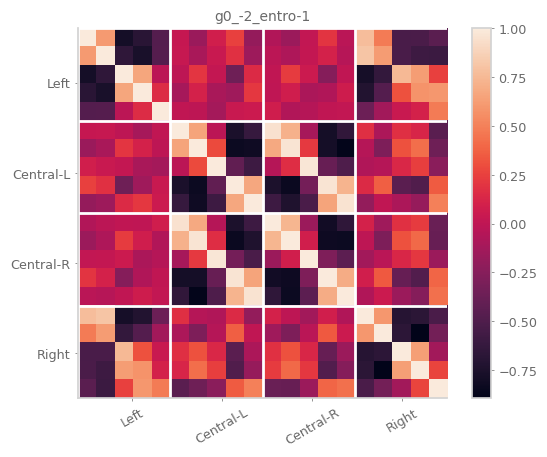

404.0


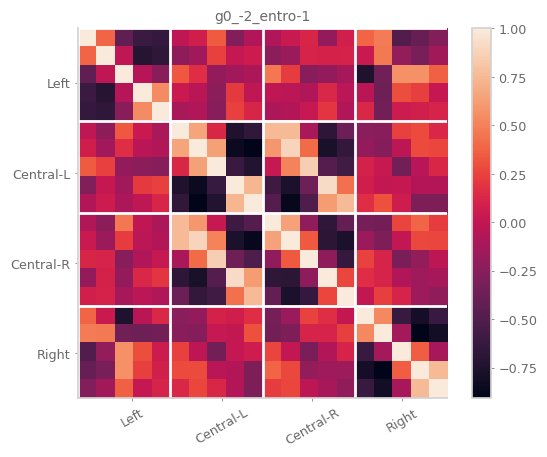

375.0
380.0
375.0
380.0
415.0


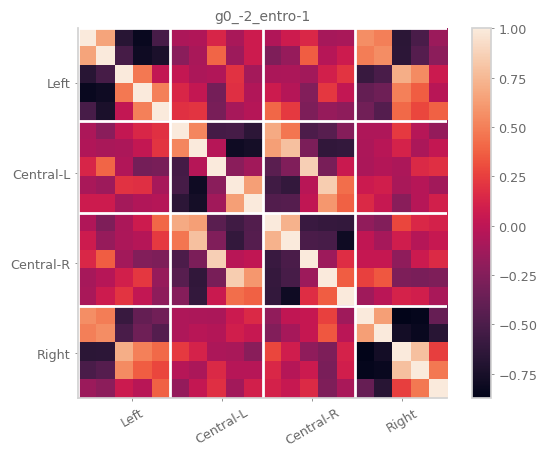

415.0


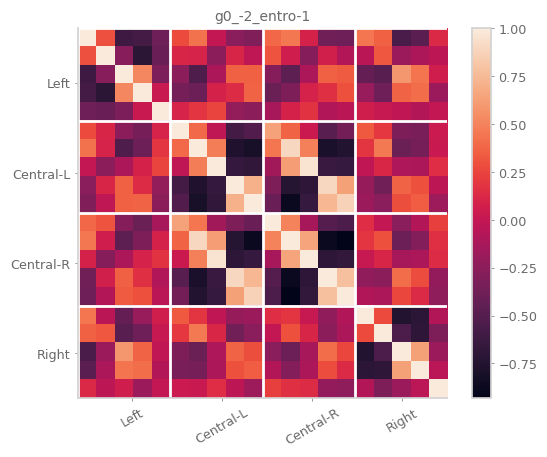

385.0
413.0


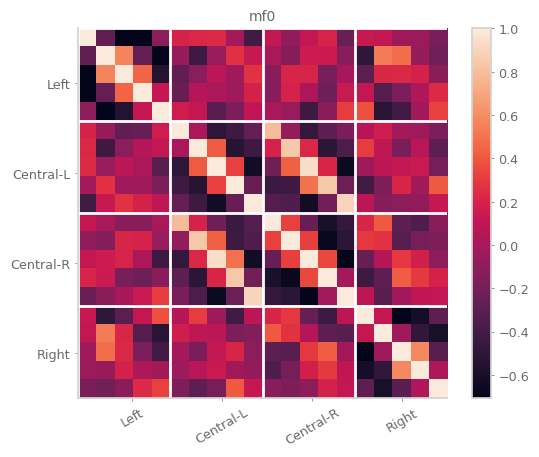

405.0


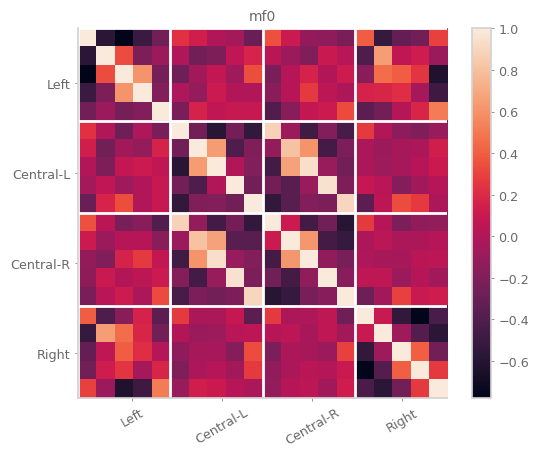

415.0


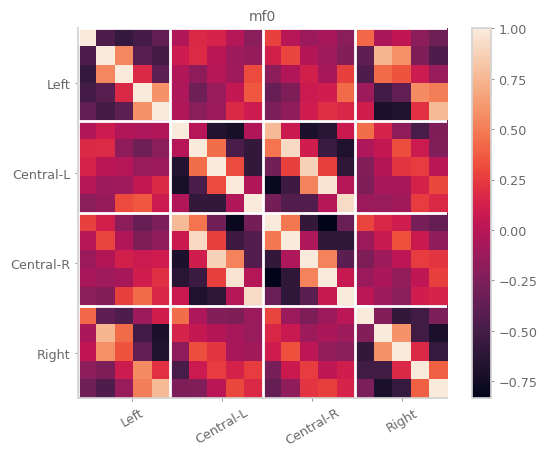

404.0


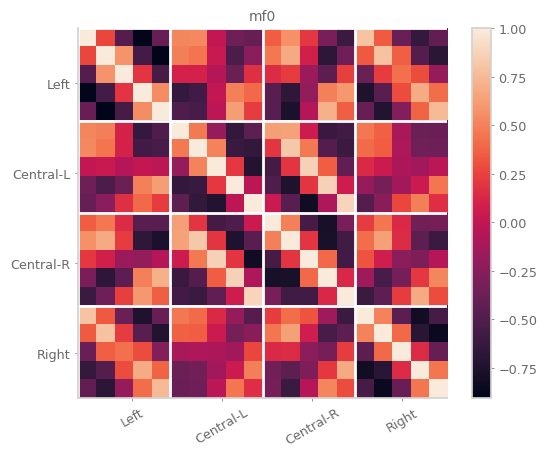

351.0
405.0


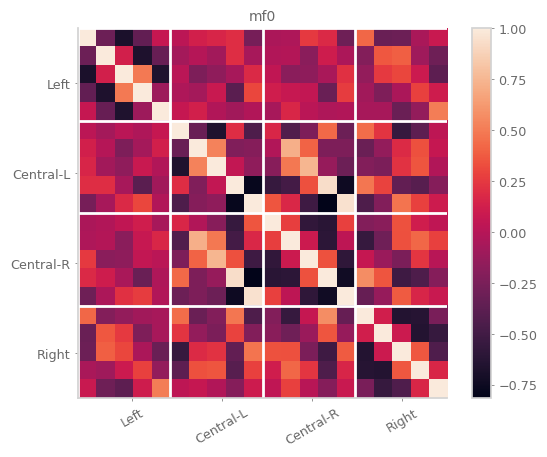

415.0


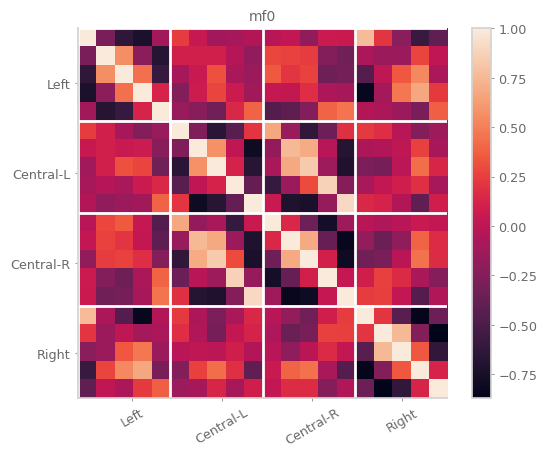

415.0


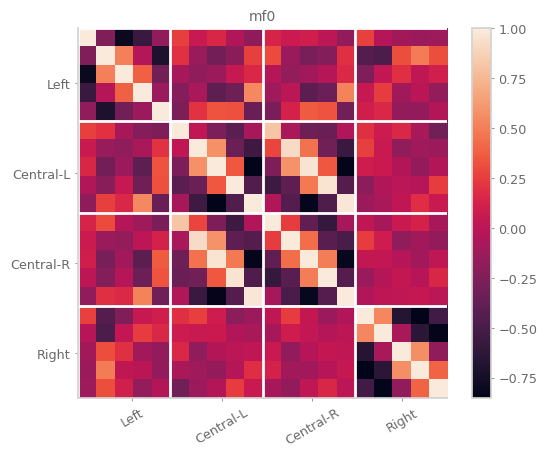

385.0
404.0


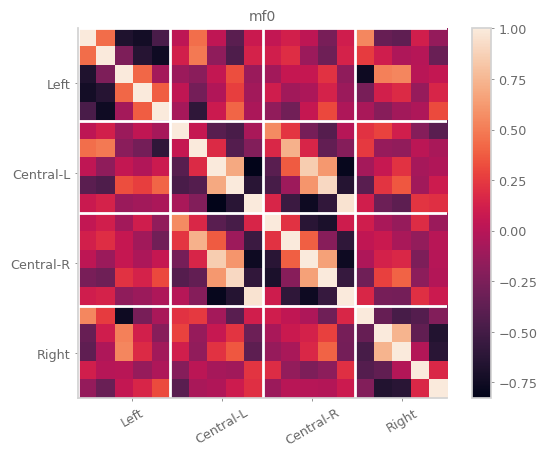

405.0


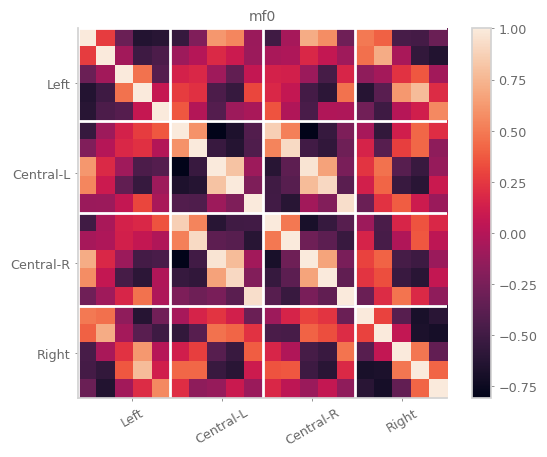

375.0
385.0
370.0
370.0
370.0
385.0
409.0


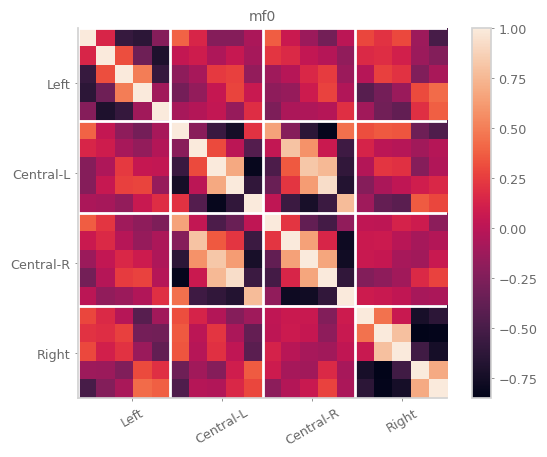

380.0
-496.0
370.0
370.0
415.0


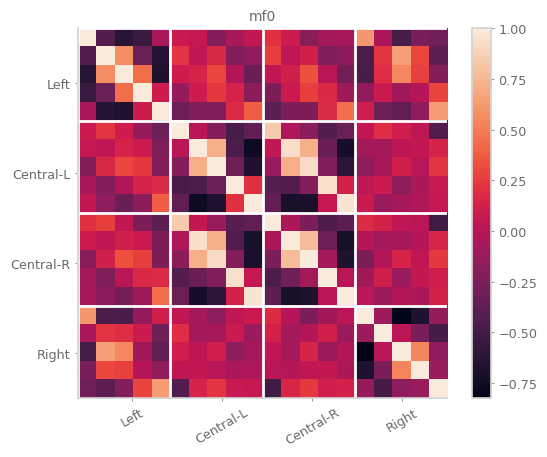

370.0
405.0


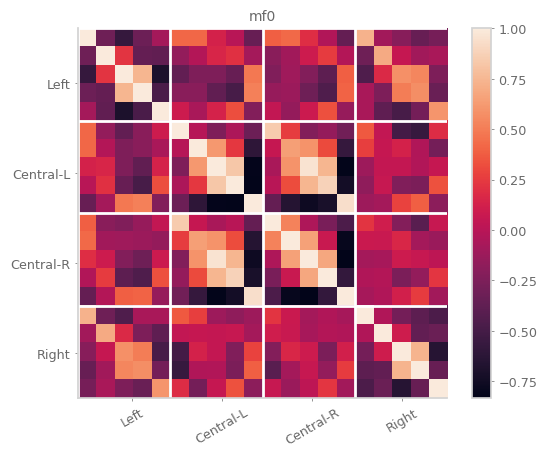

352.0
409.0


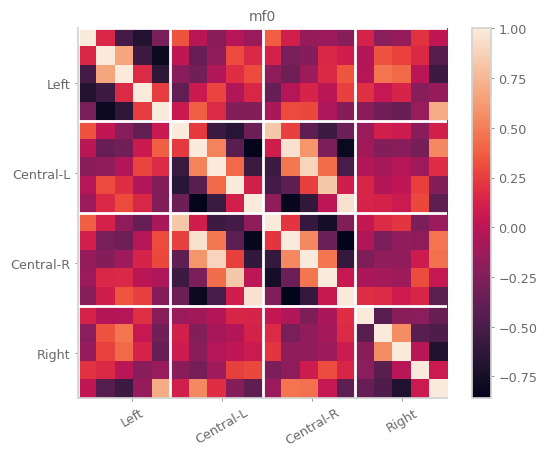

369.0
355.0
405.0


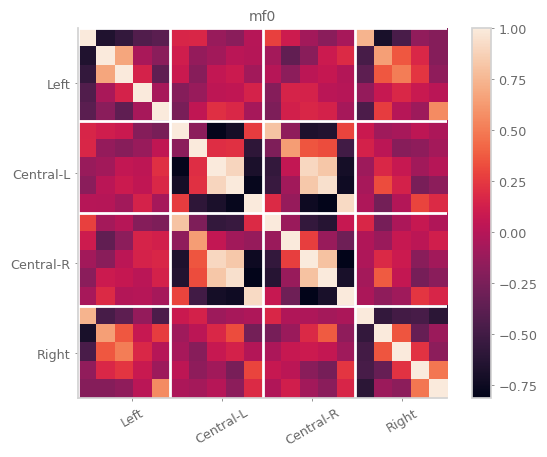

405.0


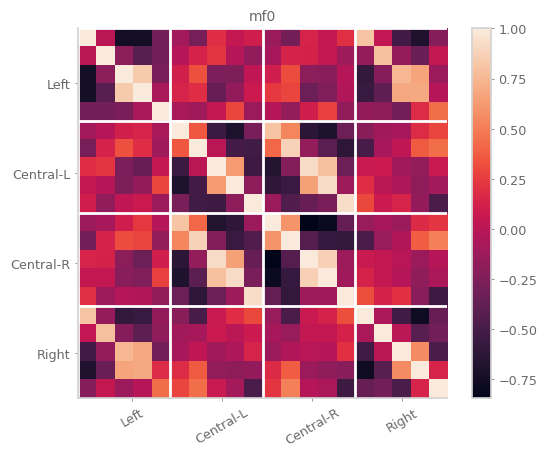

415.0


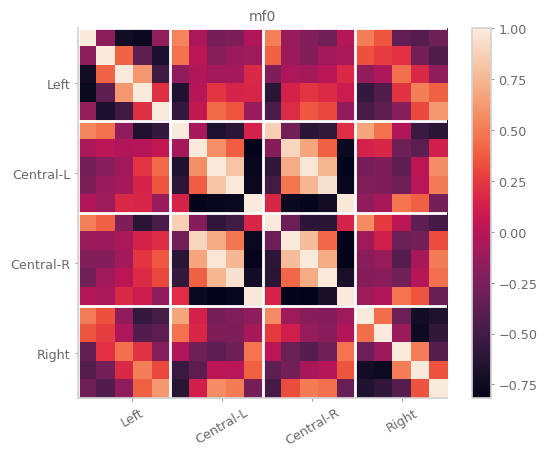

355.0
405.0


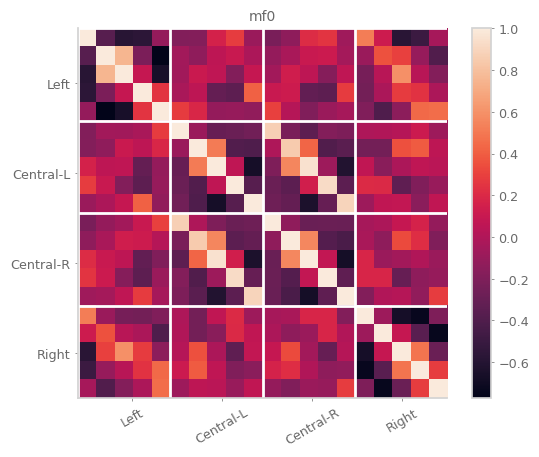

351.0


In [9]:
models = []
stem_locs = []
splits = []
iters = []
key = 'T_output'
g0_matrices = []

for model in np.unique(repr_df['model']):
    for iteration in np.unique(repr_df[repr_df['model']==model]['iteration']):
        # Initialize similarity matrix
        sim_mat = np.zeros((n_y*4, n_y*4))*np.nan
        
        # Partition dataset into the four desired conditions
        _df = repr_df[(repr_df['model']==model) & (repr_df['iteration']==iteration)]
        final_reward = _df['final_reward'].iloc[0]
        print(final_reward)
        if final_reward < (80*5): continue
        _df_L = _df[_df['x']==x_locs[0]]
        _df_LReset = _df[(_df['x']==midpoint) & (_df['reward_loc']==2)]
        _df_RReset = _df[(_df['x']==midpoint) & (_df['reward_loc']==1)]
        _df_R = _df[_df['x']==x_locs[-1]]
        _df_list = [_df_L, _df_LReset, _df_RReset, _df_R]
        
        # Get pairwise differences
        for i, df_i in enumerate(_df_list):
            for j, df_j in enumerate(_df_list):
                if j > i: continue
                i_mean = np.mean(
                    np.array(df_i[key].tolist()),
                    axis=0).squeeze()
                j_mean = np.mean(
                    np.array(df_j[key].tolist()),
                    axis=0).squeeze()
                for y_i_idx, _y_i in enumerate(y_locs):
                    for y_j_idx, _y_j in enumerate(y_locs):
                        df_i_y = np.array(df_i[df_i['y']==_y_i][key].tolist()).squeeze()
                        df_j_y = np.array(df_j[df_j['y']==_y_j][key].tolist()).squeeze()
#                         df_i_y = relu(df_i_y)
#                         df_j_y = relu(df_j_y)
                        df_i_y = np.mean(df_i_y, axis=0) - i_mean
                        df_j_y = np.mean(df_j_y, axis=0) - j_mean
                        
                        diff_norm = cos_sim(df_i_y, df_j_y)
                        sim_mat[y_i_idx + i*n_y, y_j_idx + j*n_y] = diff_norm
                        sim_mat[y_j_idx + j*n_y, y_i_idx + i*n_y] = diff_norm
        models.extend([model]*n_y)
        stem_locs.extend(range(n_y))
        reset_mat = sim_mat[n_y:2*n_y, 2*n_y:3*n_y]
        diag = np.diag(reset_mat)
        splits.extend(diag.tolist())
        iters.extend([iteration]*n_y)
        
        if 'g0' in model:
            g0_matrices.append(sim_mat)
                        
        plt.figure()
        plt.title(model)
        height = y_locs.size
        plt.imshow(sim_mat)#, vmin=0, vmax=0.9)
        for boundary in [0, height, height*2, height*3]:
            plt.axhline(boundary-0.5, linewidth=2, color='white')
            plt.axvline(boundary-0.5, linewidth=2, color='white')
        plt.xticks(
            np.linspace(0, sim_mat.shape[0]-0.5, num=9, endpoint=True)[1::2],
            ['Left', 'Central-L', 'Central-R', 'Right'], rotation=30)
        plt.yticks(
            np.linspace(0, sim_mat.shape[0]-0.5, num=9, endpoint=True)[1::2],
            ['Left', 'Central-L', 'Central-R', 'Right'])
        plt.colorbar()
        plt.show()

# Plot average similarity matrix for CPC Aux Task

In [10]:
avg_g0_matrix = np.mean(np.array(g0_matrices), axis=0)

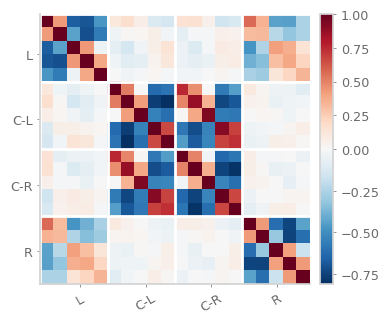

In [11]:
from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.figure(figsize=(4,4))
height = y_locs.size
cmap = plt.get_cmap('RdBu_r')
norm = TwoSlopeNorm(vcenter=0)
im = plt.imshow(avg_g0_matrix, cmap=cmap, norm=norm)
for boundary in [0, height, height*2, height*3]:
    plt.axhline(boundary-0.5, linewidth=2, color='white')
    plt.axvline(boundary-0.5, linewidth=2, color='white')
plt.xticks(
    np.linspace(0, sim_mat.shape[0]-0.5, num=9, endpoint=True)[1::2],
    ['L', 'C-L', 'C-R', 'R'], rotation=30)
plt.yticks(
    np.linspace(0, sim_mat.shape[0]-0.5, num=9, endpoint=True)[1::2],
    ['L', 'C-L', 'C-R', 'R'])
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
plt.tight_layout()
plt.show()

# Plot splitting

In [12]:
dist_df = pd.DataFrame({
    'models': models, 'stem_locs': stem_locs,
    'splits': splits, 'iteration': iters
    })

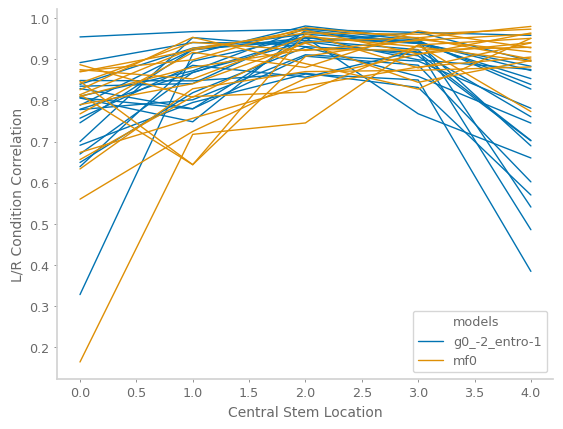

In [13]:
plt.figure()
sns.lineplot(
    x='stem_locs', y='splits', hue='models', data=dist_df,
    units='iteration', estimator=None
    )
plt.ylabel('L/R Condition Correlation')
plt.xlabel('Central Stem Location')
#plt.xticks([0, 2, 4], ['Reset', 'Middle', 'Decision Point'])
plt.show()

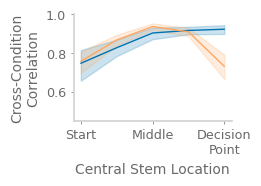

In [21]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plt.figure(figsize=(2.5,1.75), constrained_layout=True)
sns.lineplot(
    x='stem_locs', y='splits', hue='models', 
    hue_order=['mf0', 'g0_-2_entro-1'], data=dist_df,
    palette=['C0', colors(c_steps[0])],
    legend=None
    )
plt.ylabel('Cross-Condition\nCorrelation')
plt.xlabel('Central Stem Location')
plt.ylim(0.45, 1)
plt.xticks([0, 2, 4], ['Start', 'Middle', 'Decision\nPoint'])
plt.savefig('3e.png', dpi=300, transparent=True)
plt.show()

# Plot 3D latents

In [15]:
model = 'g0_-2_entro-1'

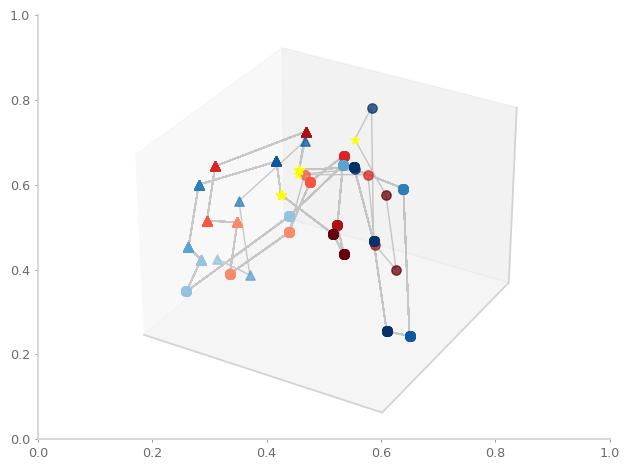

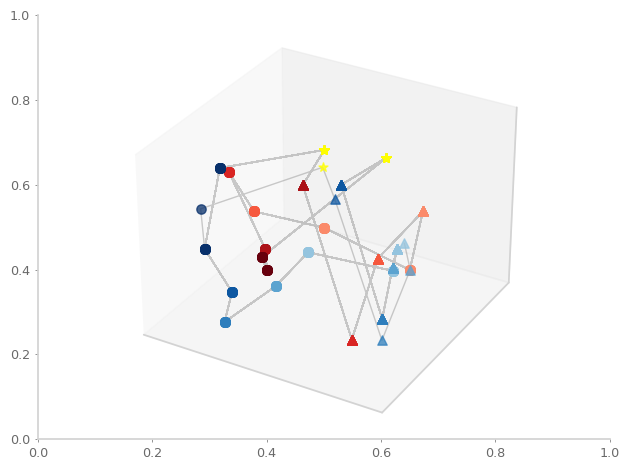

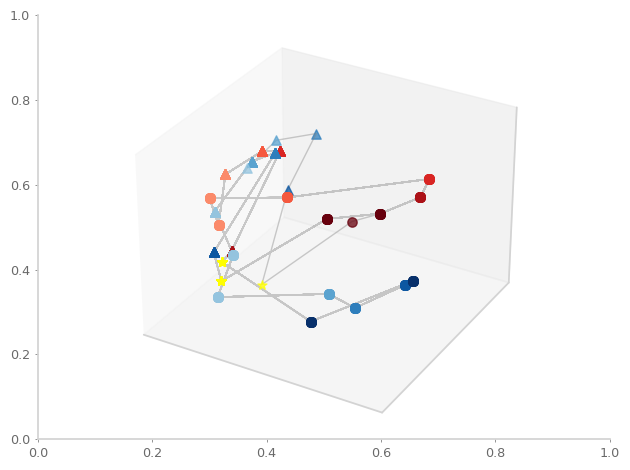

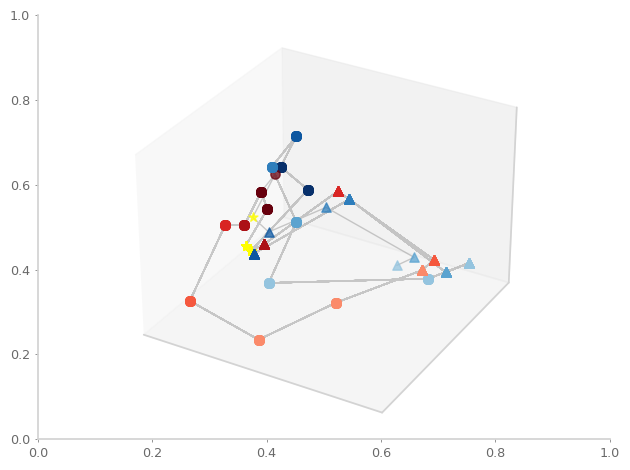

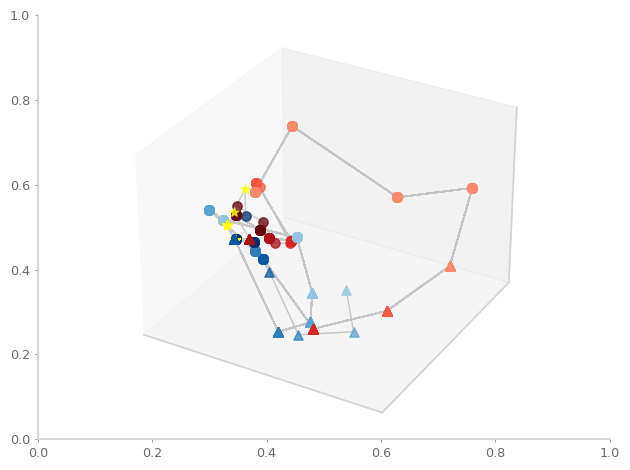

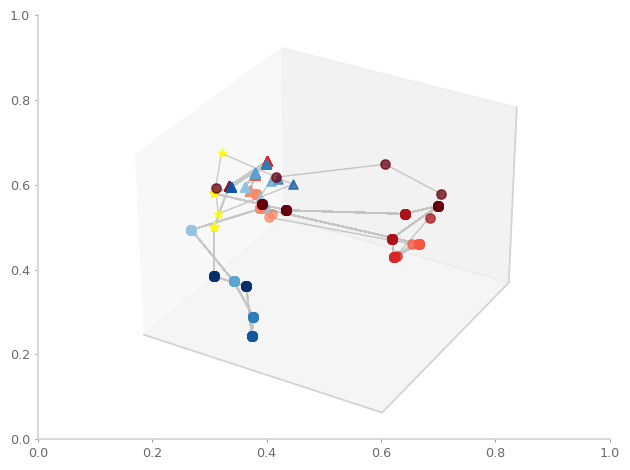

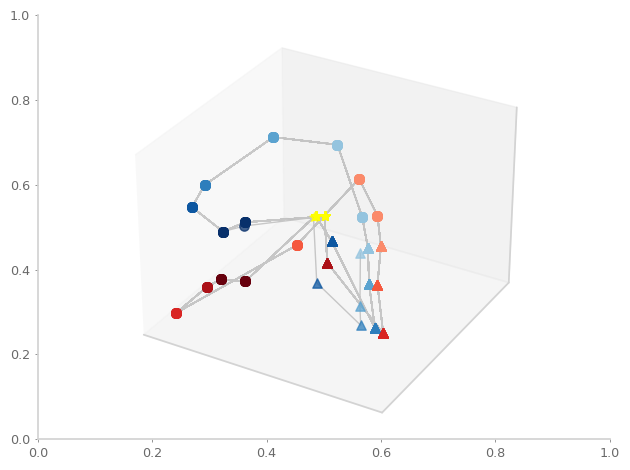

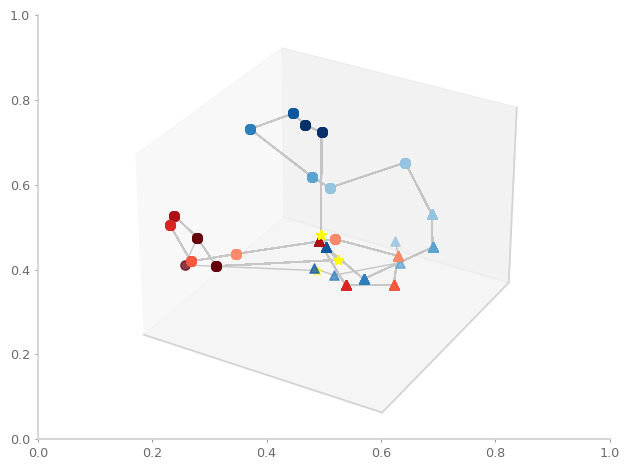

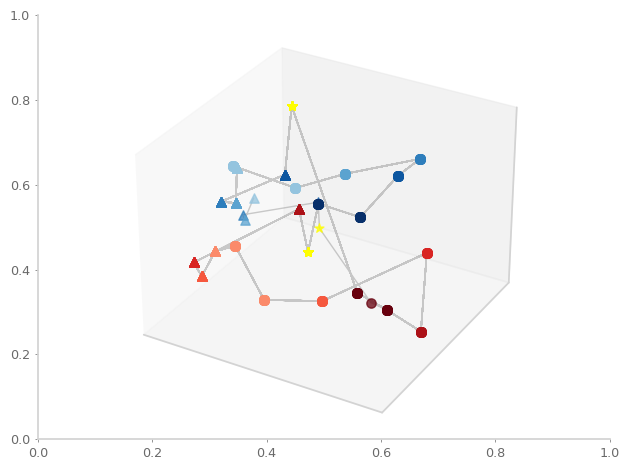

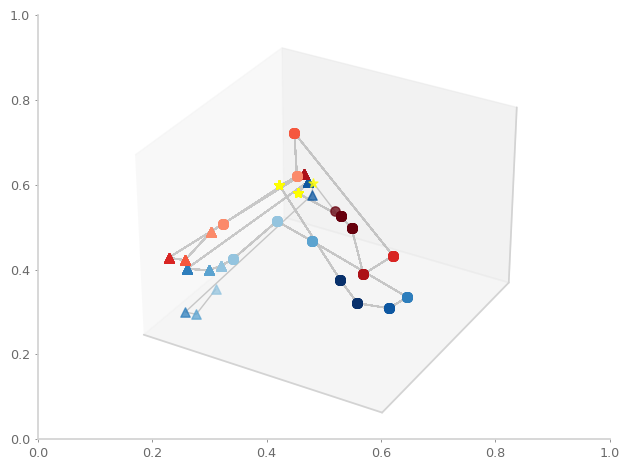

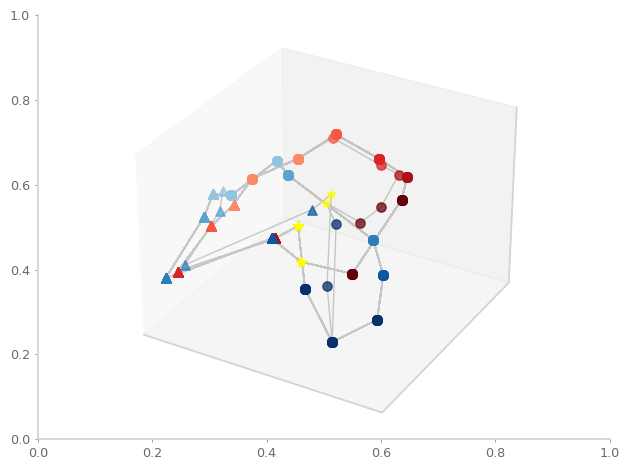

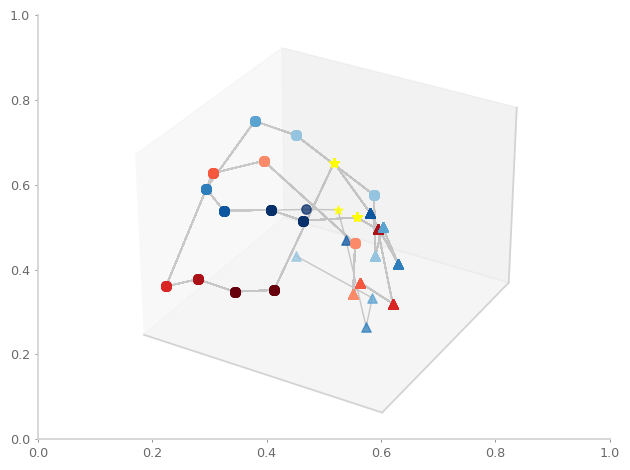

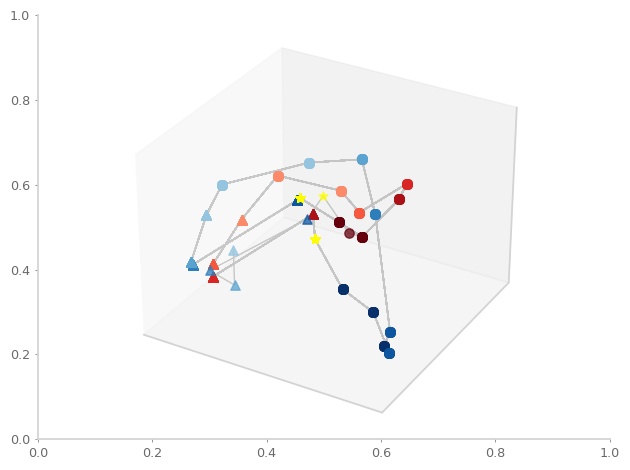

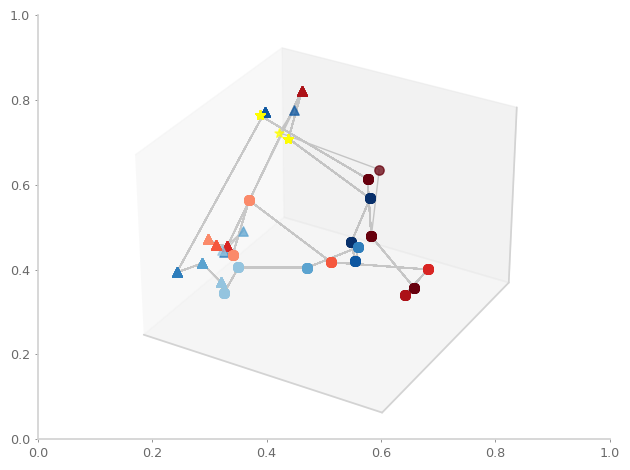

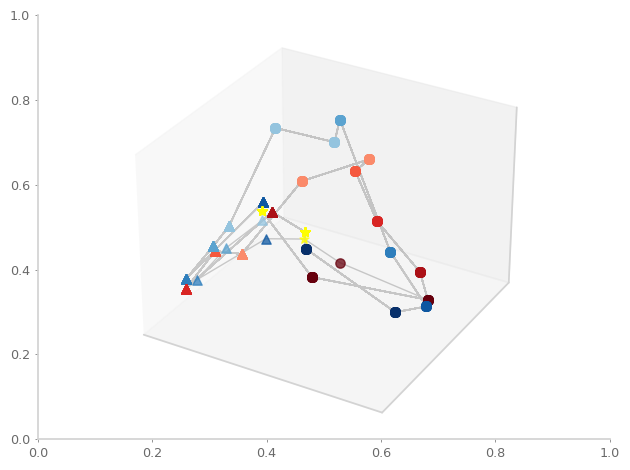

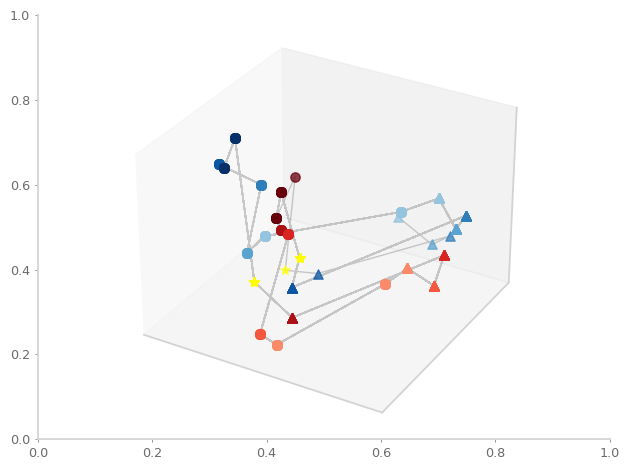

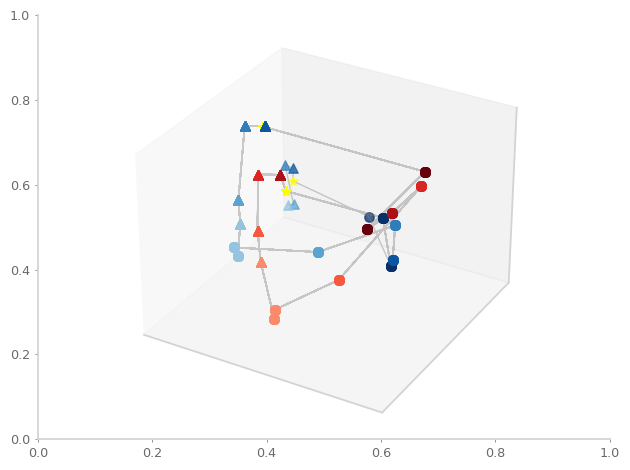

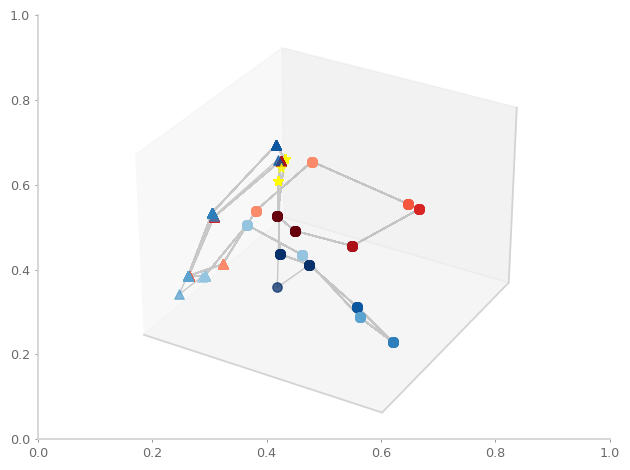

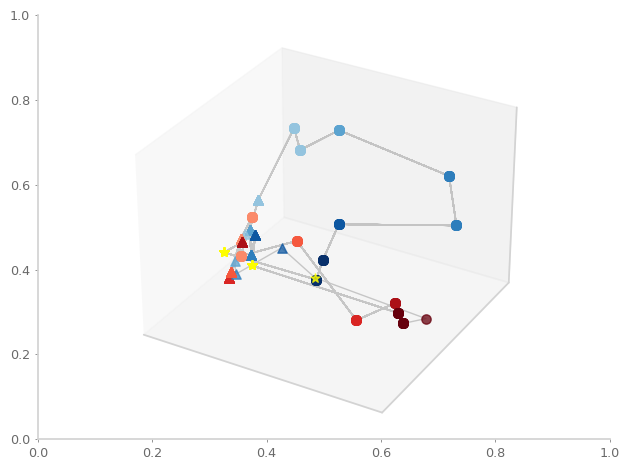

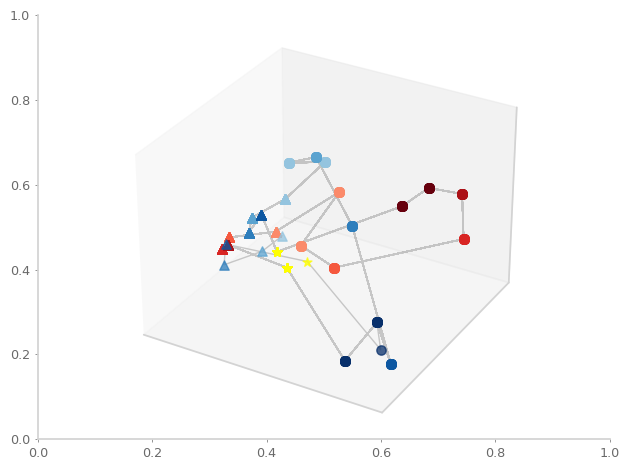

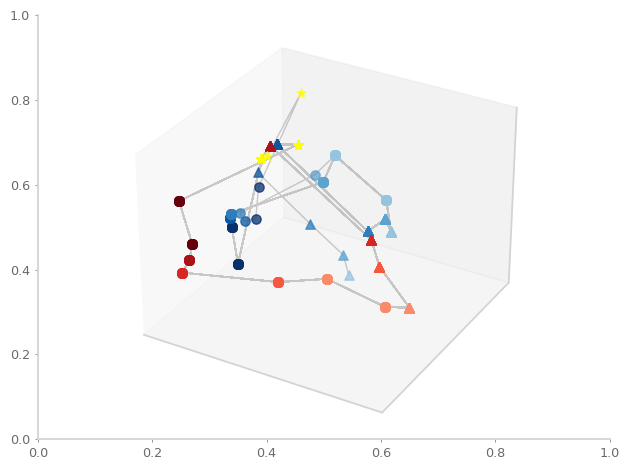

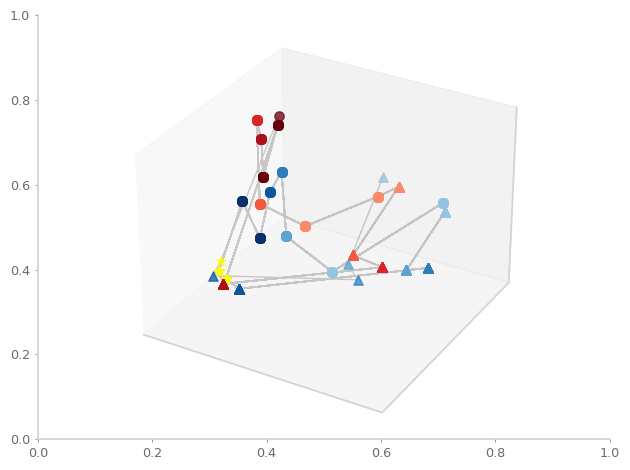

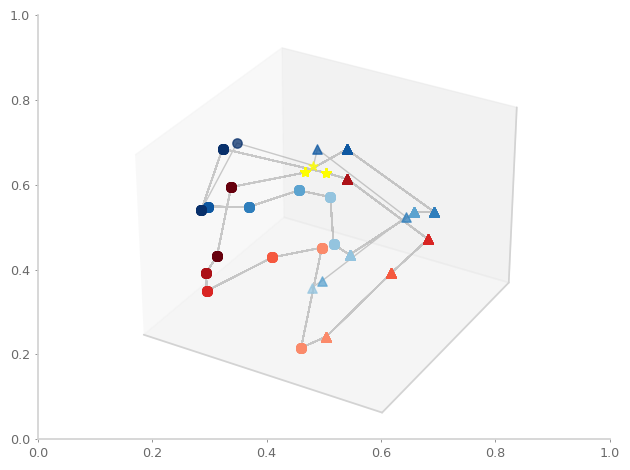

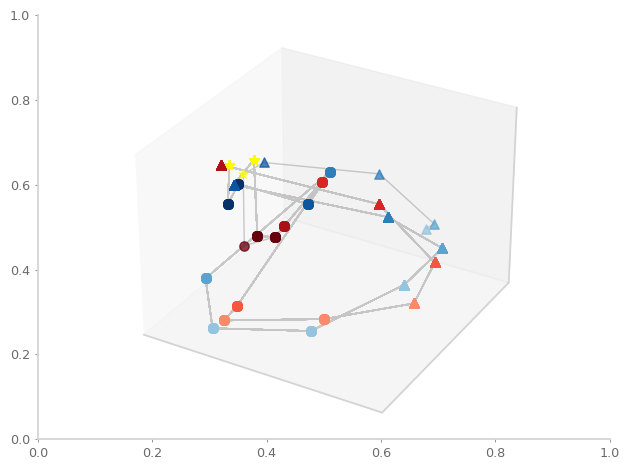

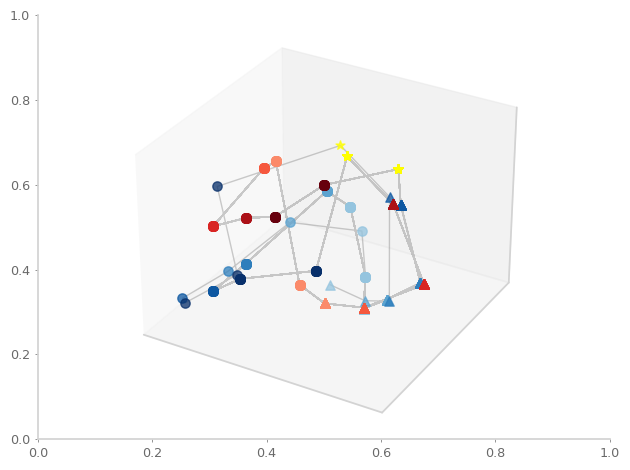

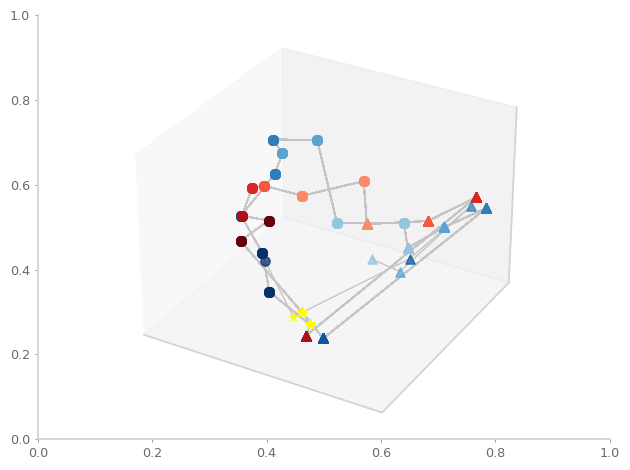

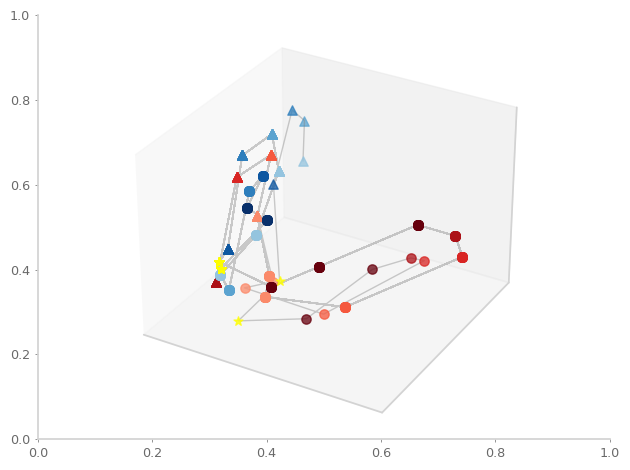

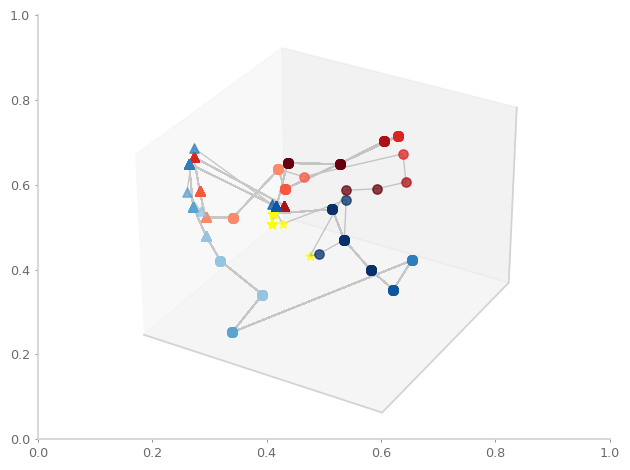

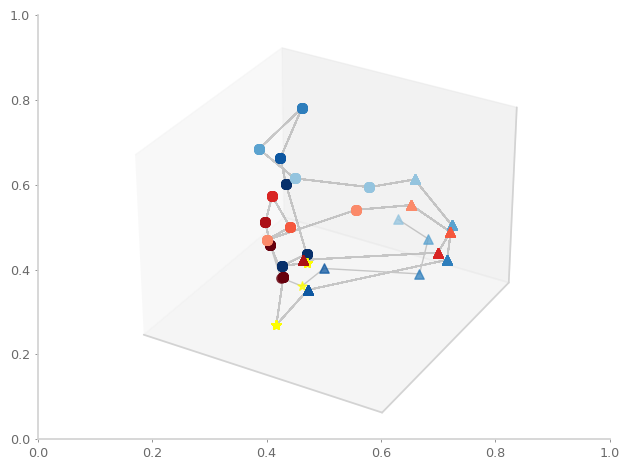

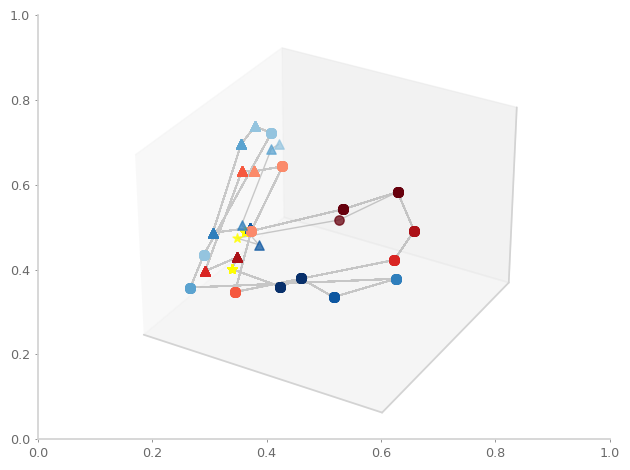

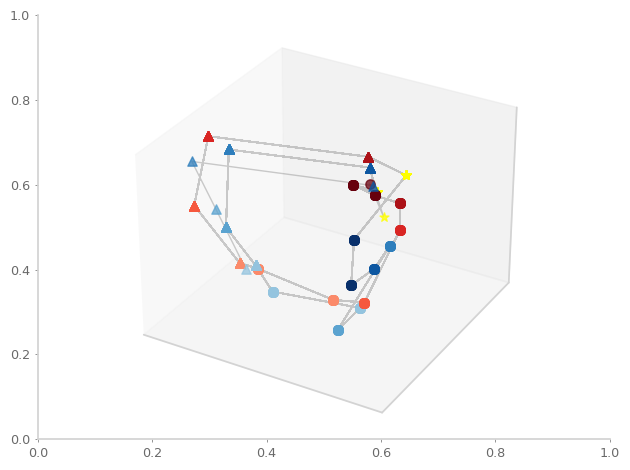

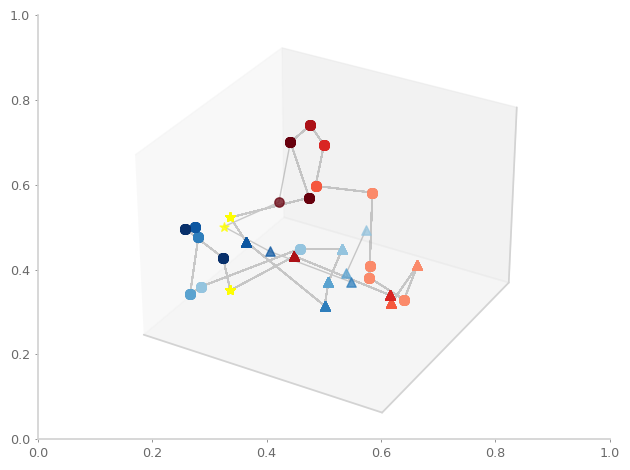

In [16]:
markers = ['s', '^', 'o']
iterations = np.unique(repr_df[repr_df['model']==model]['iteration'])
for i in iterations:
    _df = repr_df[(repr_df['model']==model) & (repr_df['iteration']==i)]
    final_reward = _df['final_reward'].iloc[0]
    if final_reward < 75*5: continue
    latents = np.array([x.tolist() for x in _df['T_output']]).squeeze()
    reducer = PCA(n_components=3)
    reducer.fit(latents)
    reduced_latents = reducer.transform(latents)
    
    fig, ax = plt.subplots()
    ax = fig.add_subplot(111,projection='3d')
    colors = [cm.get_cmap('Reds'), cm.get_cmap('Blues'), cm.get_cmap('Greys')]
    color_steps = np.linspace(0.25, 1., y_locs.max()+1, endpoint=True)
    markers = ['s', '^', 'o']
    for i in np.arange(reduced_latents.shape[0]):
        condn_label = _df.iloc[i]['condn_label']
        reward_loc = _df.iloc[i]['reward_loc']
        x = _df.iloc[i]['x']
        y = _df.iloc[i]['y']
        if condn_label == 0: # Decision point
            color_step = color_steps[y]
            color = 'yellow' 
            marker = '*'
        elif condn_label == 3: # Central Stem
            color_step = color_steps[y] # Height determines darkness
            color = colors[reward_loc-1](color_step) # Condition determines color, R/L/Re
            marker = '^'
        elif condn_label == 1: # Left side of Maze
            color_step = color_steps[y]
            color = colors[0](color_step) # Accidentally flipped color
            marker = 'o'
        elif condn_label == 2:
            color_step = color_steps[y] # Right side of Maze
            color = colors[1](color_step)
            marker = 'o'
        else:
            print('error')
        ax.scatter(
            reduced_latents[i,0], reduced_latents[i,1], reduced_latents[i,2],
            color=color, marker=marker, alpha=0.75, s=45
            )
    ax.plot(
        reduced_latents[:,0], reduced_latents[:,1], reduced_latents[:,2],
        color='gray', alpha=0.4
        )
    plt.xticks([]);plt.yticks([])
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    plt.tight_layout()
    plt.savefig('altT_latents.png', dpi=300)
    plt.show()